In [1]:
pip install ultralytics supervision -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Aqueel\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
from ultralytics import YOLO
import supervision as sv
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the frame


In [4]:
model=YOLO('yolov8x.pt')
model.fuse() #for faster inference

YOLOv8x summary (fused): 112 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


In [5]:
CLASS_NAMES_DICT = model.model.names
#CLASS_NAMES_DICT

In [6]:
#class ids of interest - car, motorcycle, bus, truck
classes = [2,3,5,7]

# Plot Frame from Video

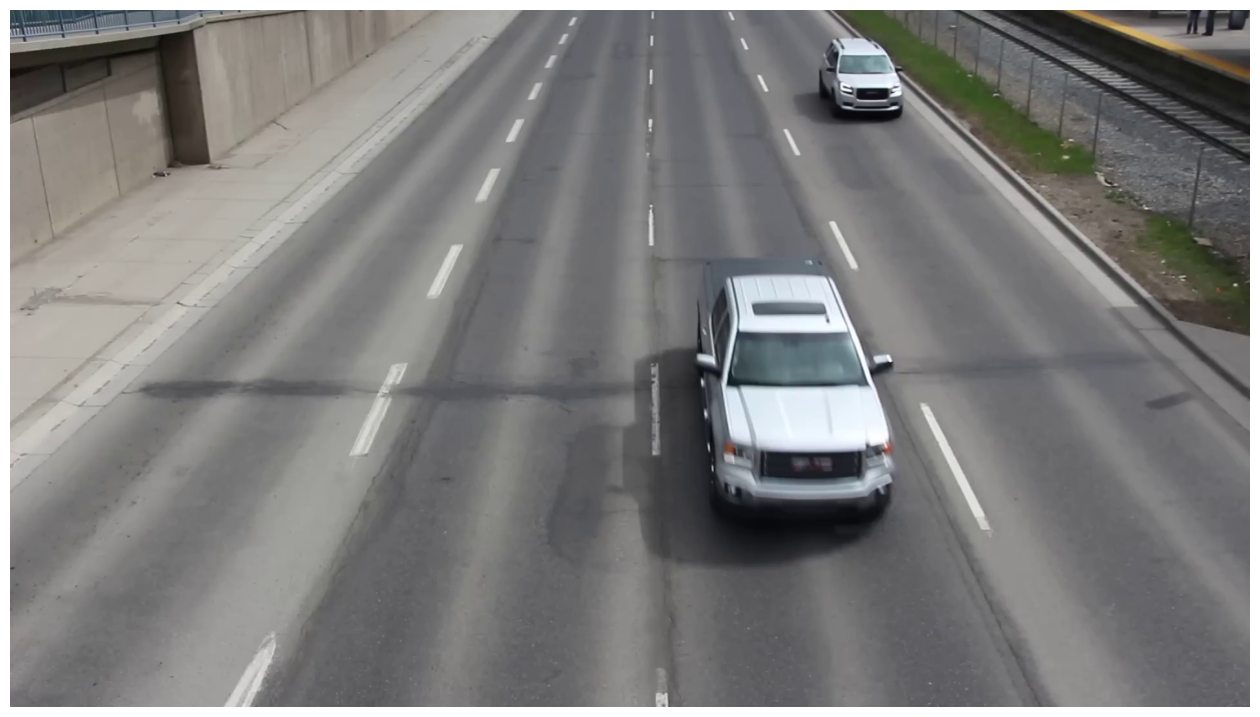

In [7]:
from collections.abc import Iterator
#create frame generator
generator = sv.get_video_frames_generator('Cars-Moving-On-Road-Stock-Footage.mp4')

#get the first frame
iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (16,10))

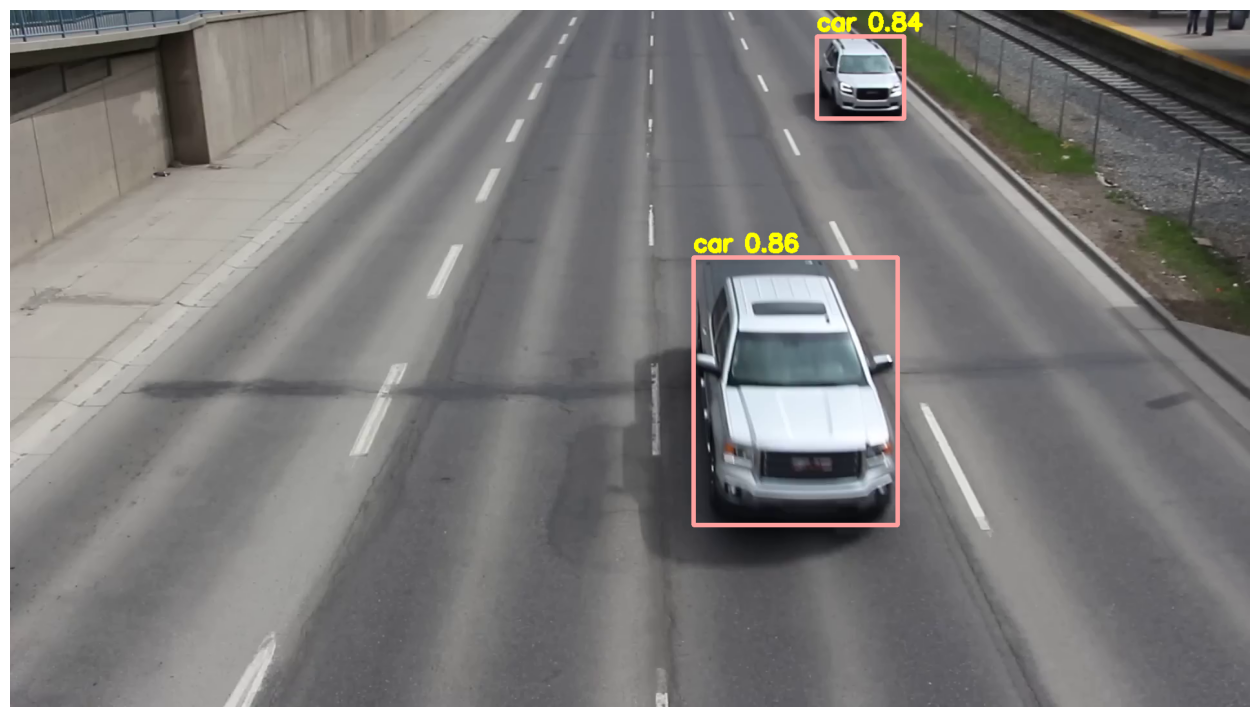

In [10]:
#detect vehichles from the frame
results = model(frame, verbose=False)[0]
#convert to detections
detections = sv.Detections.from_ultralytics(results)
#only consider classes which we required
detections = detections[np.isin(detections.class_id, classes)]
#create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=6)
#annotate the frame
Annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)
#format labels

labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    labels.append(f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}")

#overlay labels in the boundingbox
for box, label in zip(detections.xyxy, labels):
    x1,y1,x2,y2 = box.astype(int)
    #add the label above the bbox
    cv2.putText(Annotated_frame, label, (x1,y1-10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.2, color=(0,255,255), thickness=6)
#plot the annotated frame
sv.plot_image(Annotated_frame, (16,10))

# Track and Count Vehichles

In [11]:
sv.VideoInfo.from_video_path('Cars-Moving-On-Road-Stock-Footage.mp4')

VideoInfo(width=1920, height=1080, fps=29, total_frames=716)

In [12]:
#line config
LINE_START = sv.Point(0,500)
LINE_END = sv.Point(1280,500)
#create bytetracker instance
byte_tracker = sv.ByteTrack(frame_rate=25)
#create linezone counter instance
line_counter = sv.LineZone(start=LINE_START, end=LINE_END)
#create linezone annotator
line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1)
#create box annotator
box_annotator = sv.BoxAnnotator(thickness=2)
#create trace annotator
trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=60)

In [15]:
#define the function for processing frames
def process_frame(frame):
  #get results from model
  results = model(frame, verbose=False)[0]
  #convert to detections
  detections = sv.Detections.from_ultralytics(results)
  #only consider classes which we required
  detections = detections[np.isin(detections.class_id, classes)]
  #tracking detections
  detections = byte_tracker.update_with_detections(detections)
  #create labels
  labels = []
  for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
    labels.append(f"{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}")
  #update trace annotator
  Annotated_frame =  trace_annotator.annotate(scene=frame.copy(), detections=detections)
  #update box annotator
  Annotated_frame = box_annotator.annotate(scene=Annotated_frame, detections=detections)

  #overlay labels in the boundingbox
  for box, label in zip(detections.xyxy, labels):
      x1,y1,x2,y2 = box.astype(int)
      #add the label above the bbox
      cv2.putText(Annotated_frame, label, (x1,y1-10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4, color=(0,255,255), thickness=1)

  line_counter.trigger(detections)
  #update linezone annotator
  Annotated_frame = line_zone_annotator.annotate(Annotated_frame, line_counter=line_counter)

  return Annotated_frame

In [ ]:
#run the program
video_path = 'Cars-Moving-On-Road-Stock-Footage.mp4'
#get input from webcam
#video_cap = cv2.VideoCapture(0) #capture from webcam
#get input from video
video_cap = cv2.VideoCapture(video_path)

while True:
  success,frame = video_cap.read()
  if not success:
    break
  #resize frame
  frame = cv2.resize(frame, (1280,720))
  #convert to RGB
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  #process frame
  proccessed_frame = process_frame(frame)
  #display the frame
  cv2.imshow('High way vehichles Tracking & Counting', proccessed_frame)
  #exit if any key pressed
  if cv2.waitKey(1) & 0xFF !=255:
    break
video_cap.release()
cv2.destroyAllWindows()